# Exploration 11 - 뉴스기사 요약하기 

이번 프로젝트는 자연어 프로젝트 중, seq2seq 모델의 어텐션(Attention) 메커니즘을 사용하여 문장을 요약하는 프로젝트이다.   
seq2seq 모델은 LSTM을 기반으로 한 모델로 인코더 부분과 디코더 부분으로 나누어 입력(인풋)을 인코더 부분에 넣고 LSTM이 학습하는 과정을 거친 후 이를 컨텍스트 벡터(context vector)형태로 변환한다. 그 다음으로 변환된 context vector을 디코더 부분에 넣어 예측할 문장을 생성하는 것이다.   
   
기본적인 개념에 대한 설명이었고, 실제로 위 모델을 사용하여 본문에서 중요한 단어를 LSTM 어텐션 메커니즘을 사용하여 학습한 후 얼만큼의 요약문을 만들어낼 수 있는지 확인해보겠다.

## 필요한 모듈 import

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj58/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1. 데이터 준비하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

뉴스요약에 사용될 데이터를 준비한다.   
데이터는 위 코드를 통해 다운받을 수 있으며, data라는 변수에 pandas를 사용하여 불러온 후 Step 2에서 전처리를 진행하겠다.

In [3]:
print(len(data))

98401


전체 데이터는 98401개를 가지고 있다.   
데이터 형태를 살펴보면, headlines와 text부분으로 나뉘는데, text는 뉴스의 본문 내용이며 headlines는 뉴스의 제목이다.   
headlines는 앞으로 학습할 모델에서 lable로 지정되는데 정확한 요약문은 아니더라도 본문에 내용을 충분히 반영하고 있다고 생각한다.

In [4]:
data.head(10)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


# Step 2. 데이터 전처리하기

## 1. 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


`nunique`를 사용하여 중복되지 않은 값을 확인할 수 있다.

In [6]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


중복된 값들을 `drop_duplicates` 메서드를 사용하여 날려준다.   
하지만 NULL로 중복되어있는 한개의 값이 남아있으므로 확인 후 drop 해주도록 한다.

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


NULL값은 없는걸로 확인된다.

## 2. 텍스트 정규화와 불용어 제거

### (1) 텍스트 정규화 사전 구성

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


위의 텍스트 정규화 사전은 아래 링크를 참고하여 만들어졌다.   
정규화 사전 출처 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

### (2) 불용어 제거

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하고 제공한 불용어를 사용한다. 총 179개의 불용어를 제거할 수 있다.

### (3) 대/소문자 구분, html 태그 제거, 특수문제 제거

In [10]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

`preprocess`함수를 만들어 모든 글자를 소문자화하고, html 태그를 제거하고, 특수문자를 제거하도록 한다.   
불용어 제거는 본문 부분에서만 제거하고, summarize되는 부분에서는 문장이 자연스럽게 이어지도록 불용어 제거를 하지 않는다.

In [11]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

전처리된 text(본문)을 clean_text라는 변수를 새로 만들어 넣어준다.

In [12]:
clean_headlines = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

headlines도 동일하게 `preprocess_sentence` 함수를 활용하여 전처리를 해준다. 다만, 불용어를 제거하는 부분은 False값을 주도록 한다.

In [13]:
data['Text'] = clean_text
data['Summary'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

clean_text와 clean_headlines에 append된 전처리된 텍스트셋을 다시 data의 column으로 입력해준다.   
그리고 한번 더 NULL값이 있는지 확인한다.

In [14]:
data.isnull().sum()

headlines    0
text         0
Text         0
Summary      0
dtype: int64

처음과 동일하게 NULL값은 확인되지 않는다.

## 3. Train, Test data split

### (1) 샘플의 최대 길이 정하기

train 데이터와 test 데이터셋을 나누기 전에, **text**와  **headlines**의 분포를 확인하여 최소, 최대, 평균길이를 확인해보고 적절한 값으로 맞춰준다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


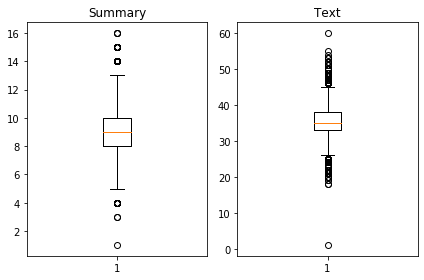

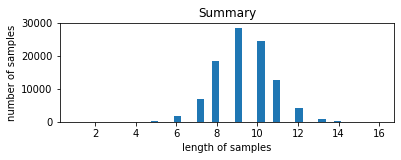

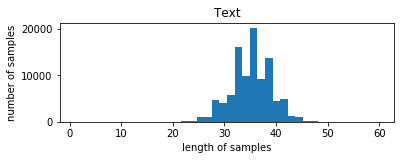

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.subplot(2,1,1)
plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.subplot(2,1,2)
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

**먼저 text 분포를 분석해보면,**   
최대길이는 60이지만 대부분의 길이가 20이상, 45이하에 분포되어 있어 보인다.   
   
   
**다음으로 headlines의 분포를 분석해보면,**   
요약의 최대 길이는 16이지만, 대부분 6에서 12사이의 값을 가진 것으로 확인된다.

위 분석을 가지고 아래와 같이 text의 최대길이와 headlines의 최대길이를 지정해주겠다.

In [16]:
text_max_len = 45
summary_max_len = 12

위에서 정한 text와 headlines의 max_len값이 실제 데이터셋에서 어느정도의 분포를 가지는지 확인하기 위한 함수를 만들어본다.

In [17]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


생각보다 너무 정리가 안된느낌이 있긴 하지만 일단은 진행하도록 하겠다.

In [19]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 96871


text와 headlines의 max_len에 대해서 최대길이만큼 문장을 짜르는 것이 아니라, 최대 길이보다 짧은 문장은 제거하도록 한다.

## (2) seq2sea 시작토큰과 종료토큰 추가하기

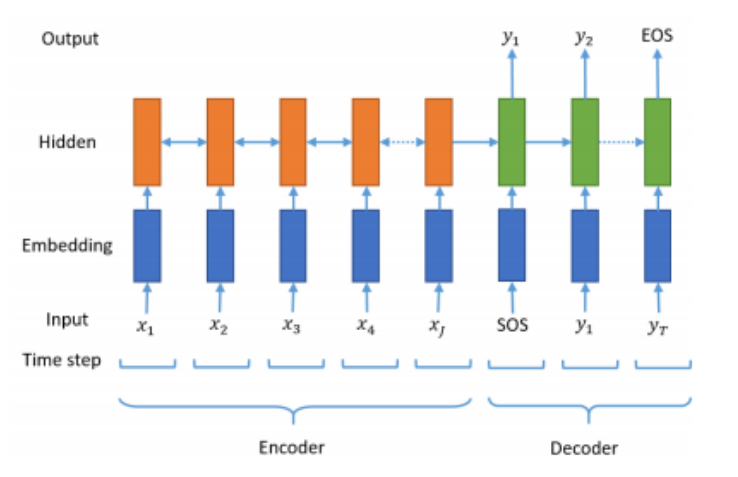

In [20]:
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,Text,Summary,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


데이터에 **decoder_input**과 **decoder_target** 컬럼값을 추가하여 **headlines문장**을 기준으로,   
**decoder_input**에는 시작을 나타내는 **sostoken**을 추가하고   
**decoder_target**에는 종료를 나타내는 **eostoken**을 입력한다.

### 모델에 학습을 시키기 위해서 numpy형태로 바꿔준다.   
#### encoder_input에는 text(본문)이 들어가며, decoder_input과 target에는 sostoken과 eostoken이 들어간 컬럼값을 넣어준다.

In [21]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## (3) Train/Test dataset split

훈련 데이터와 테스트 데이터셋을 분리하는 방법으로는 주로 `sklearn`의 `train_test_split` 메서드를 사용하였는데,   
이번에는 직접 분리하는 방법을 배워보도록 하겠다.

In [22]:
indices = np.arange(encoder_input.shape[0]) #encoder_input은 현재 96871개의 row를 가지고 있는 형태이다
np.random.shuffle(indices)
print(indices)

[91165 51522 85822 ... 25967 85995 31011]


먼저, 데이터셋을 잘 섞어준다.

In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

`np.random.shuffle(indices)`로 잘 섞어진 **indices**를 기준으로, 다시 순서를 정해준다.

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19374


8:2 비율로 트레인 데이터와 테스트 데이터를 나눠준다. 

In [25]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


## (4) 정수 인코딩, Tokenize()

In [26]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

`tokenizer()`를 활용하여 각각의 단어에 해당하는 정수를 만들어줌과 동시에 단어집합을 생성하였다.

### 빈도수가 낮은 단어는 제거 (7회를 기준으로)

In [27]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69146
등장 빈도가 6번 이하인 희귀 단어의 수: 47124
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 22022
단어 집합에서 희귀 단어의 비율: 68.15144766146993
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.519752843834011


In [28]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

희귀 단어를 제외시킬 경우의 단어 집합의 크기는 22059개 나왔다. 어림잡아 20000개 수준으로 단어 집합의 크기를 제한해보겠다.

In [29]:
print(encoder_input_train[:3])

['asteroid measuring nearly feet flew past earth wednesday distance lakh km times distance earth moon closest come last years asteroid jo discovered may came nearest earth pm ist hurtling away'
 'maharashtra government planning introduce separate category orphans appearing various competitive exams cm devendra fadnavis cited case orphan girl cleared exam could qualify general category resolve plan enact law orphans separate category said'
 'allman brothers band co founder gregg allman passed away age georgia us saturday reportedly due complications liver cancer allman band played key role pioneering southern rock music notably allman band received lifetime achievement grammy award']


현재 encoder_input_train에는 문장 그대로, 전처리가 되어, 20000개의 단어 집합의 크기를 가지고, 최대 45개의 문장길이를 가진 문장이 들어가 있다. 이제 이를 정수인코딩 `texts_to_sequences()`를 사용하여 만들어 보겠다.

In [30]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4548, 5549, 194, 983, 3441, 518, 521, 58, 2080, 63, 687, 211, 2080, 521, 1138, 7115, 274, 29, 23, 4548, 8216, 845, 115, 221, 8348, 521, 49, 17322, 223], [346, 8, 587, 2713, 1599, 1162, 17323, 3930, 787, 4227, 2546, 83, 3293, 2928, 2697, 75, 19293, 162, 1920, 1889, 89, 4355, 256, 1162, 3076, 757, 11170, 234, 17323, 1599, 1162, 1], [2578, 3264, 218, 250, 438, 223, 441, 7309, 5, 85, 22, 112, 8896, 6559, 1038, 3264, 400, 1812, 373, 15281, 3710, 2656, 870, 105, 3264, 254, 4258, 5127, 11171, 490]]


위 문장과 동일한 문장이 이제는 정수로 출력되는 것을 확인할 수 있다.   
컴퓨터는 텍스트 형태의 문장보다는 숫자를 인식하도록 프로그래밍 되어 있으므로 이 작업을 수행한다고 볼수 있다.

### headlines에도 동일하게 낮은 빈도수의 단어를 제거해준다.

In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29885
등장 빈도가 5번 이하인 희귀 단어의 수: 19516
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10369
단어 집합에서 희귀 단어의 비율: 65.30366404550779
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.699075618509785


In [33]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2716, 1931, 17, 533, 12, 861, 140, 373, 741, 5125], [1, 344, 23, 379, 1658, 5, 4, 6766, 1628], [1, 2143, 3075, 112, 415, 284, 12], [1, 2777, 459, 50, 1301, 6, 5126, 1211, 124], [1, 249, 1069, 1219, 137, 300, 15, 277, 30, 1816]]
target
decoder  [[2716, 1931, 17, 533, 12, 861, 140, 373, 741, 5125, 2], [344, 23, 379, 1658, 5, 4, 6766, 1628, 2], [2143, 3075, 112, 415, 284, 12, 2], [2777, 459, 50, 1301, 6, 5126, 1211, 124, 2], [249, 1069, 1219, 137, 300, 15, 277, 30, 1816, 2]]


다음 스텝은 패딩인데, 그 전에 희귀 단어가 제거된 문장들을 보면 희귀 단어들로만 구성된 경우 문장이 빈값을 가지고 있을 수 있다.   
실제로는 시작 토큰과 종료 토큰이 포함되어 있으므로 길이가 1인 문장들을 살펴보자.

In [34]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]
print(drop_train, drop_test)

[] []


없는 것으로 확인된다.

## (5) 패딩 (Padding)

앞에서 지정해두었던 최대길이를 기준으로 post padding을 해준다.

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

# Step 3. 어텐션 메커니즘 (Attention Mechanism) 사용하기 (추상적 요약)

##  모델 정의하기

### 인코더 모델

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 디코더 모델

In [37]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [38]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 어텐션 메커니즘 정의

In [39]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [40]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 모델 학습!!

epoch을 50으로 놓고 모델 학습을 진행한다. loss가 2회이상 낮아질 경우 early stop이 되도록 설정되어 있다.

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
303/303 [==============================] - 118s 391ms/step - loss: 5.6216 - val_loss: 5.1933
Epoch 2/50
303/303 [==============================] - 111s 368ms/step - loss: 5.0433 - val_loss: 4.8132
Epoch 3/50
303/303 [==============================] - 112s 369ms/step - loss: 4.6850 - val_loss: 4.5139
Epoch 4/50
303/303 [==============================] - 112s 368ms/step - loss: 4.4228 - val_loss: 4.3465
Epoch 5/50
303/303 [==============================] - 114s 377ms/step - loss: 4.2219 - val_loss: 4.1917
Epoch 6/50
303/303 [==============================] - 113s 372ms/step - loss: 4.0482 - val_loss: 4.0761
Epoch 7/50
303/303 [==============================] - 112s 368ms/step - loss: 3.8946 - val_loss: 3.9712
Epoch 8/50
303/303 [==============================] - 112s 370ms/step - loss: 3.7615 - val_loss: 3.8902
Epoch 9/50
303/303 [==============================] - 113s 374ms/step - loss: 3.6464 - val_loss: 3.8349
Epoch 10/50
303/303 [==============================] - 114s 376m

### Loss값을 그래프로 그려보면 다음과 같다.   
epoch은 5정도가 적당해보인다.

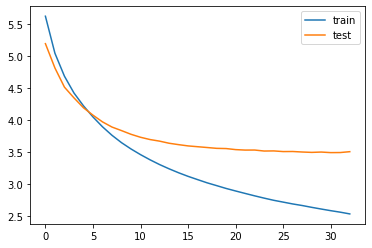

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기

seq2seq 모델은 인퍼런스 단계에서는 만들어야할 문장의 길이만큼 디코더가 반복 구조로 동작해야하기 때문에 인퍼런스를 위한 모델을 별도로 설계해주어야한다고 한다. 인코더 모델과 디코더 모델을 분리해서 설계해야한다고 하는데 이 부분은 잘 이해하지 못했다.

In [43]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [44]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [45]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [46]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

테스트에서는 정수 시퀀스를 텍스트 시퀀스로 변환시켜줘야 하기때문에 원문과 요약문의 함수 `seq2text`와 `seq2summary` 이라는 함수를 각각 정의한다.

In [47]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## 텍스트문 불러오기

모든 준비가 다 되었고, 이제 encoder_input_test에 있는 텍스트문 10개를 불러와 실제 요약문과 예측 요약문을 비교해본다.

In [48]:
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : year old man allegedly committed suicide hanging friday aurangabad district maharashtra police said note found house mentioned debts lack reservation maratha community reasons behind act deceased also requested son provided reservation death police added 
실제 요약 : man ends life suicide note mentions debt and maratha quota 
예측 요약 :  man commits suicide after maratha quota demand for maratha quota


원문 : billionaire mukesh ambani led reliance industries reportedly planning new plant jamnagar refinery capacity process much million tons crude year proposed plant world biggest refining complex boost company refining capacity half new plant estimated cost billion reports said 
실제 요약 : reliance plans to expand world largest refinery complex reports 
예측 요약 :  reliance to invest in up to power power for bn


원문 : state owned carrier air india saturday announced launch red eye flights domestic destinations starting november red eye flight generally late night arrives early morning air india 

생각만큼... 요약이 잘 된다고 보여지지는 않는다. 아마 에폭이 너무 커졌기 때문에 그럴수도 있다고 생각한다.

# Step 5. Summa을 이용해서 추출적 요약해보기

다음으로는 Summa를 이용하여 추출적 요약을 해보겠다.   
먼저 summarize 모듈을 import한다.

In [59]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [60]:
from summa.summarizer import summarize

원본 데이터를 text_summa라는 변수에 담고, pandas로 읽어온 후 str 형태로 바꿔준다.

In [61]:
text_summa = str(data['text'])

10번째부터 20번째 문장을 원문과 summarize를 비교해본다.   
ratio는 0.4 이하는 좋은 문장의 형태가 나오지 않아 0.5로 값을 지정해줬다.

In [87]:
for i in range(10, 20):
    print("원문 :", text_summa[i])
    print("추출적 요약문:", summarize(text_summa[i], ratio=0.5))
    print('\n')

원문 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture.
추출적 요약문: Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.


원문 : Isha Ghosh, an 81-year-old member of Bharat Scouts and Guides (BSG), has been imparting physical and mental training to schoolchildren in Jharkhand for several decades. Chaibasa-based Ghosh reportedly walks seven kilometres daily and spends eight hours conducting physical training, apart from climbing and yoga sessions. She says, "One should do something for society till one's last breath."
추출적 요약문: Isha Ghosh, an 81-year-

### ratio가 0.5도 부족했는지 요약이 되지 않은 문장들도 보인다. 하지만 전체적으로 요약은 seq2seq보다 더 잘된것으로 보인다. 중요한 키 포인트를 더 잘 잡아냈으며, 문장의 형태를 보이고 있고, 요약이 더 잘되었다.